# Time Series Classification

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Dataset

### Load TSV data

In [ ]:
# load data
base_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

def read_data(file_path):
  data = np.loadtxt(file_path, delimiter="\t")
  x = data[:,1:]
  y = data[:,0]
  return x, y.astype(int)

x_train, y_train = read_data(base_url + "FordA_TRAIN.tsv")
x_test, y_test = read_data(base_url + "FordA_TEST.tsv")

print(f"Training data shape: {x_train.shape, y_train.shape}")
print(f"Test data shape: {x_test.shape, y_test.shape}")

Training data shape: ((3601, 500), (3601,))
Test data shape: ((1320, 500), (1320,))


### Visualize data

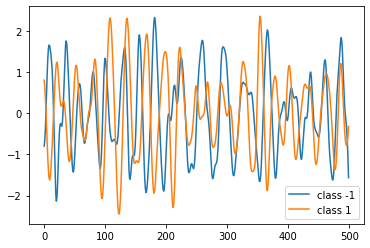

In [ ]:
# plot data
def plot(x, y):
  classes = np.unique(y)
  plt.figure()
  for c in classes:
    c_x = x[y == c]
    plt.plot(c_x[0], label="class " + str(c))
  plt.legend(loc="best")
  plt.show()

plot(x_train, y_train)

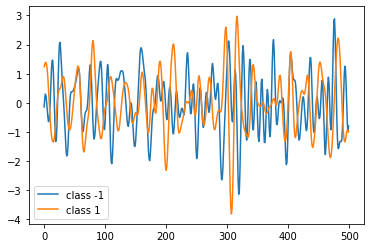

In [ ]:
plot(x_test, y_test)

### Standardize data

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [ ]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [ ]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [ ]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

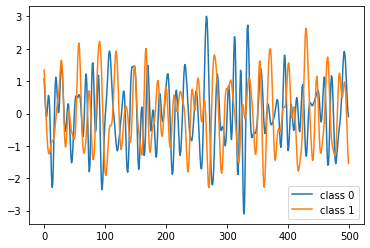

In [ ]:
plot(x_train, y_train)

## Build a Model

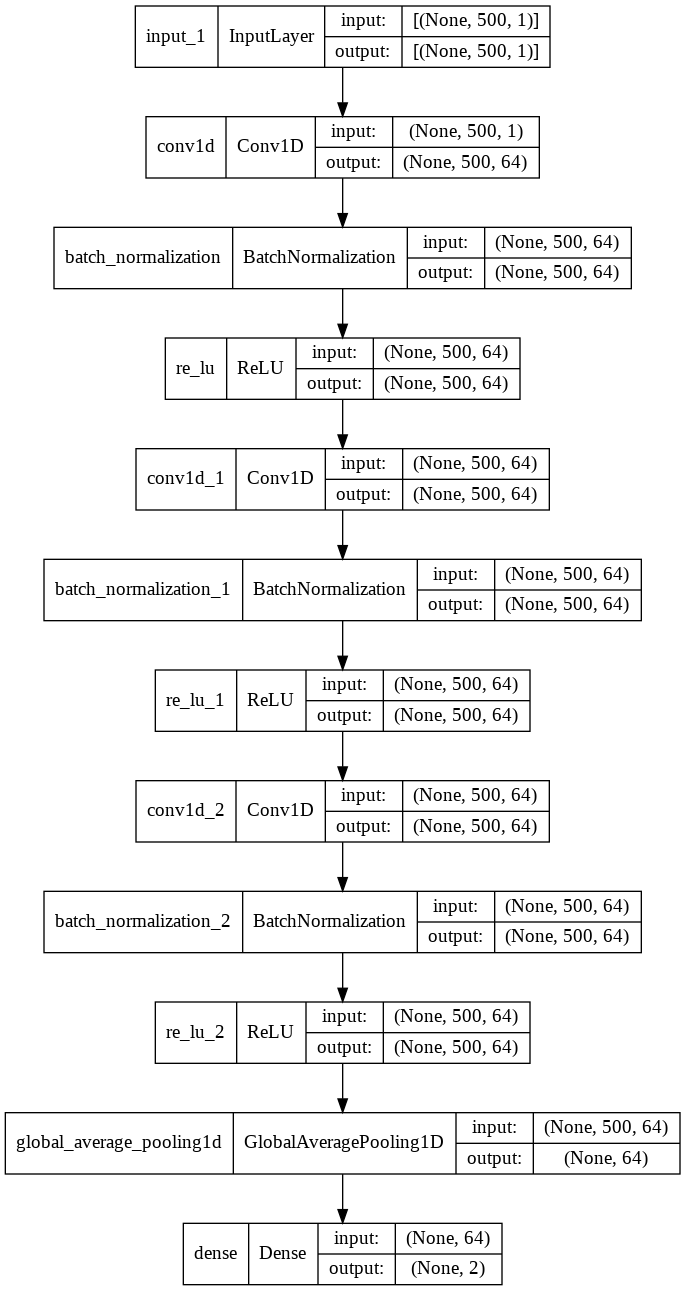

In [ ]:
def make_model(input_shape):

  input_layer = keras.layers.Input(input_shape)

  conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.ReLU()(conv1)

  conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.ReLU()(conv2)

  conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.ReLU()(conv3)

  gap = keras.layers.GlobalAveragePooling1D()(conv3)

  output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

  return keras.models.Model(input_layer, output_layer)

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
             keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)
]

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_split=0.2,
                    verbose=1
                    )


Epoch 1/500
90/90 [==============================] - 14s 129ms/step - loss: 0.5684 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.7013 - val_sparse_categorical_accuracy: 0.5173 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 11s 125ms/step - loss: 0.4681 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.5173 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 11s 127ms/step - loss: 0.4355 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.4646 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 11s 126ms/step - loss: 0.4227 - sparse_categorical_accuracy: 0.7910 - val_loss: 0.6599 - val_sparse_categorical_accuracy: 0.6061 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 11s 125ms/step - loss: 0.4260 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.5921 - val_sparse_categorical_accuracy: 0.6921 - lr: 0.0010
Epoch 6/500
90/90 [======

## Evaluate model on test data

In [ ]:
#mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
model = keras.models.load_model("best_model.h5")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy is {test_accuracy}")
print(f"Test loss is {test_loss} ")

42/42 [==============================] - 1s 27ms/step - loss: 0.0953 - sparse_categorical_accuracy: 0.9705
Test Accuracy is 0.9704545736312866
Test loss is 0.09527990221977234 


## Plot model training curves

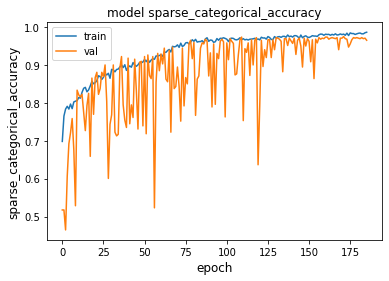

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()